In [2]:
# importing the MNIST dataset
from sklearn.datasets import fetch_openml
import numpy as np
# fetch_* functions load reaal-life datasets
# load_* fucntons load small toy datasets
# make_* functions make fake datasets
# The generated datasets are returend as (X, y) tuples
# The generated datasets contain input data and targets as NumPy arrays
# Other datasets are returned as sklearn.utils.Bunch objects
# These datasets are dictionaries whose entries can be accessed
# The attirbutes for access are: "DESCR", "data", "target"
# DESCR: returns the description of the dataset
# data: The input data, usually as a 2D NumPy array
# target: The labels, usually as 1D numpy array
mnist = fetch_openml('mnist_784', as_frame=False)
# fetch_openml() returns data as pandas df and labels as pandas series
# This is unusual for MNIST dataset which contains images and isnt ideal
# To get data as NumPy arrays instead we set "as_frame=False" 

/home/umarsajjad/anaconda3/envs/sklearn_env/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# Let's store the data into variables for ease of access
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
# Let's take a look at the shapes of the X (inputs) and y (labels)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


* As can seen by the shape of the inputs, there are a total of 70,000 images and each image has 784 features (num pixels-28x28 pixel image)
* Each feature can have a value between 0(white) and 255(black)

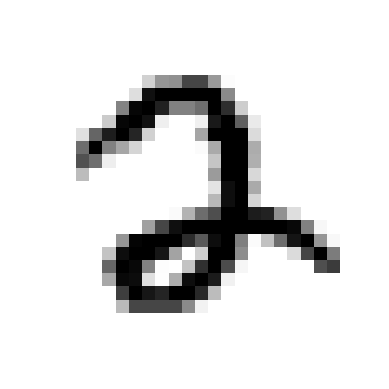

In [5]:
# Let's take peak at one example from the dataset
# Let's make function that plots the digit
import matplotlib.pyplot as plt
from numpy import random
# we are going to use imshow() function of matplotlib to display the image
# we use cmap="binary" to get a grayscale color map (0=white, 255=black)

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Let's plot the image
dig_ind = random.randint(70000)
digit = X[dig_ind]
plot_digit(digit)
plt.show()

In [6]:
# This looks like a one, let's look at the label to verify
y[dig_ind]

'2'

In [7]:
# Before we do any preprocessing and inspection it is essential we split
# The data to ensure we don't mess around with the test data
# Let's split the data into train and test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

## Binary Classfication

In [103]:
# Let's now train and binary classifier
# This binary classifier will check if the number is 5 or not (2 classes)
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
# Let's pick a classifier and train it
from sklearn.linear_model import SGDClassifier

# Defining an instance of the classifier with random state 42
clf = SGDClassifier(random_state=42)
# Fitting the classifier to the data
clf.fit(X_train, y_train_5)

# Let's look at indexes where 5 exists
y_5s_index = np.where(y_test_5)[0]

# Let's predict a number where it is 5 or not
ind = y_5s_index[0]
digit = X_test[ind]
clf.predict([digit])

array([ True])

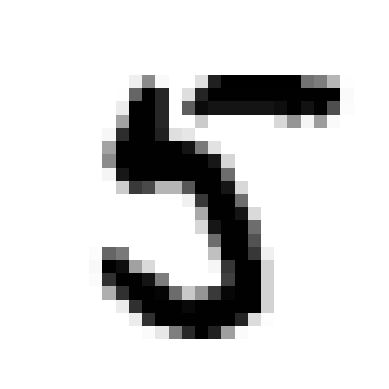

In [9]:
# Let's verify whether the predicting is correct or not
plot_digit(digit)

* Indeed the model classified the number 5 correctly

## Evaluating the Performance Metrics of the Classifier

### Measuring Accuracy Using Cross-Validation

In [10]:
# Let's use cross_val_score() function to evaluate our model
# k-fold cross validation will be utilized with 4 folds
# k-fold cross validation means splitting the training set in k-folds(4)
# Then traing the model k times, holding out a different fold each time for evaluation
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train, y_train_5, cv=4, scoring='accuracy')

array([0.95435714, 0.96121429, 0.963     , 0.96728571])

* 95-96% accuracy seems very exciting but we need to delve deeper to determine whether it's a good model
* Considering only 10% of data is the number 5, if you were to guess that every number is not 5, you will be right 90% of the time.
* Thus accuracy is generally not the preferred performance measure for classifiers
* This is especially true if you are dealing with skewed datasets (datasets in which some classes are much more frequent than others)
* A much better way to evaluate the performance of a classifier is to look at the <b>Confusion matrix (CM)</b>

#### Implementing Cross-Validation
* Occasionally you will need more control over the cross-validation process than what scikit-learn provides off the shelf
* You can implement your own cross-validation

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=4, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))

0.9539285714285715
0.9651428571428572
0.9612142857142857
0.9635714285714285


### Confusion Matrices

In [12]:
# The confusion matrix counts the number of times Instances of class A
# are classified as class B, for all A/B pairs
# To compute the confusion matrix you first need to have a set of predictions
# These predictions will be used to compare to the actual targets
# Let's use cross_val_predict() function
# This function returns predictions made on each test fold rather than
# the evaluation scores
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, X_train, y_train_5, cv=4)

In [13]:
# Let's now look at the confusion matrix by comparing y_train_5 and y_train_pred
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[50170,   790],
       [ 1368,  3672]])

* Each row in a confusion matrix represents an actual class
* Each column represents a predicted class
* In this particular case: 
    * The first row of this matrix considers non-5 images (the negative class): 49237 of them were correctly classified as non-5s. These are called <b>True Negatives</b>
    * While the remaining 1295 in the row were wrongly classified as 5s (<b>False positives</b>, also called type I)
    * The second row considers the images of 5s (The postive class): 2597 as non-5s (<b>False negatives</b>, also called type II errors)
    * While the remaining 2871 in the row were correctly classified as 5s (<b>True positives</b>, also called type I)
    * perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)
* The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric.
* An interesting one to look at is the accuracy of the positive predictions; this is called the <b>Precision</b> of the classifier. 
* <b>Precision</b> = $TP / (TP + FP)$, where TP is the number of true positives, and FP is the number of false positives.
* Precision is typically used along with another metric named <b>Recall</b>, also called sensitivity or the <b>True Positive Rate (TPR)</b>: this is the ratio of positive instances that are correctly detected by the classifier.
* <b>Recall or TPR</b> =  $TP / (TP + FN)$, where TP is the number of true positives, and FN is the number of false negatives.
* Example Image: 
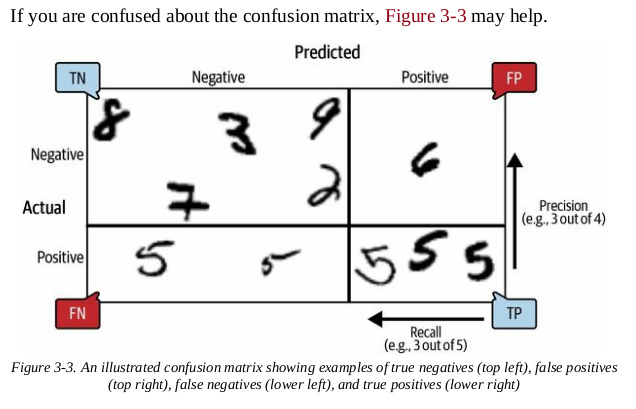

In [95]:
# Let's calculate the Precision and Recall of our classifier
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8229493500672345
0.7285714285714285


* Now the model does not look as good as it did with just the accuracy metric
* It is also convenient to combine the precision and recall metrics into a single metric called <b>F1 score</b>.
* The <b>F1 score</b> is the harmonic mean of precision and recall
* Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.
* The classifier will only get a high F1 score if both recall and precision are high
* <b>F1 Score</b> = $2 * (precision * recall)/(precision + recall)$

In [15]:
# Let's compute the F1 score of our classifier
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7728899179120187


* The F1 score favors classifiers that have similar precision and recall
* This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall
* For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones(high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection).
* On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).
* Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

### The Precision/Recall Trade-off
* To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions
* For each instance, it computes a score based on a <b>decision function</b>
* F1 that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class
* Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions
* Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance and then use any threshold you want to make predictions based on those scores

In [16]:
# Let's predict using the SGD classifier and set it's threshold
# We will use the decision_function() to get a score4
y_scores = clf.decision_function([digit])
y_scores
y_pred_dig = clf.predict([digit])
y_pred_dig

array([ True])

In [17]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

* If we set the theshold low, such as 0, we will get the same score as the predict() method

In [18]:
# Let's raise the threshold and see what happens
threshold = 3000
y_some_digit_pred = (y_scores  > threshold)
y_some_digit_pred

array([ True])

* Raising the threshold to a high value descreases the recall, This means that if you raise the threshold, it will only consider 5s which are sure shot 5s, any image of a 5 that does is not obvious, will be considered false negatives thus decreasing recall.
* So, How do you decide which threshold to use?
    1) First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions
    2) With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold)
    3) Finally, use Matplotlib to plot precision and recall as functions of the threshold value

In [19]:
# Let's implement the above three steps
# Step 1 - cross_val_predict() function to get the scores of all instances in the training set
y_scores = cross_val_predict(clf, X_train, y_train_5,
                            cv=4, method="decision_function")

# Step 2 - use the precision_recall_curve() function to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

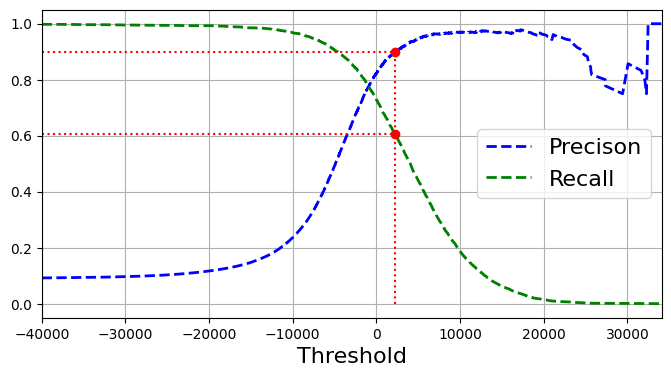

In [20]:
def plot_precision_recall_threshold_curve(threshold, precisions, recalls):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precison", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    
    # Beautifying the graph
    plt.xlim(-40000, np.max(thresholds))
    plt.grid(True)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    
# Let's get a 90% precision line
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
    
plt.figure(figsize=(8, 4))
plot_precision_recall_threshold_curve(thresholds, precisions, recalls)
plt.plot([threshold_90_precision, threshold_90_precision], [ 0., 0.90], "r:")
plt.plot([-40000, threshold_90_precision], [0.90, 0.90], "r:")
plt.plot([-40000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.90], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()


 * At this threshold value, precison is near 90% and recall is around 50%.
 * Another wat to select a good precision/recall trade-off is to plot precision directly against recall.

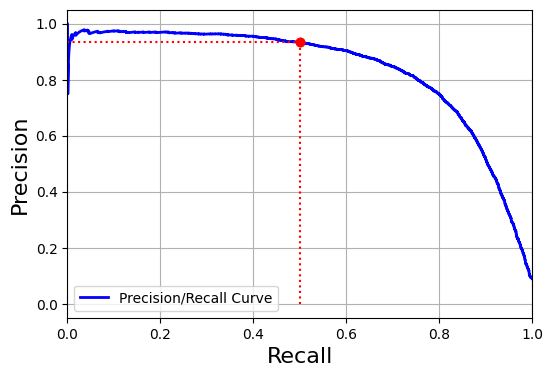

In [84]:
def plot_precision_recall_curve(precisions, recalls, label="Precision/Recall Curve", style="b-"):
    plt.plot(recalls, precisions, style, linewidth=2, label=label)
    
    # Beautifying the graph
    plt.xlim(0.0, np.max(recalls))
    plt.grid(True)
    plt.legend(loc="lower left", fontsize=10)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)

precision_50_recalls = precisions[np.argmax(recalls <= 0.50)]

plt.figure(figsize=(6, 4))
plot_precision_recall_curve(precisions, recalls)
plt.plot([0.50, 0.50], [0, precision_50_recalls], 'r:')
plt.plot([0.0, 0.50], [precision_50_recalls, precision_50_recalls], 'r:')
plt.plot([0.50, 0.50], [precision_50_recalls,precision_50_recalls], 'ro')
plt.show()

* This graph illustrates that as the precision increases, the recall decreasea and vice versa
* It is thus advisable to select a Precision vs Recall value that works for the problem at hand
* You can see that precision really starts to fall sharply at around 80% recall
* You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project

In [56]:
# Suppose you decide to aim for 90% precision. 
# You could use the first plot tofind the threshold you need to use, 
# but that’s not very precise
# Alternatively, you can search for the lowest threshold that gives you at least 90% precision
# For this, you can use the NumPy array’s argmax() method. 
#This returns the first index of the maximum value, 
# which in this case means the first True value
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

2191.6267600055344

In [59]:
# To make predictions (on the training set for now), 
# instead of calling the classifier’s predict() method, you can run this code
y_train_pred_90 = (y_scores >= threshold_90_precision)
# Let’s check these predictions’ precision and recall
precision_score = precision_score(y_train_5, y_train_pred_90)
recall_score = recall_score(y_train_5, y_train_pred_90)
print(precision_score)
print(recall_score)

0.9001178550383029
0.6061507936507936


* This might look great that you achieved 90% precision but the recall is only 60 %
* Depending on the problem, this may be great or not so great

### $\color{red}{\text{Important Note}}$
* If someone says, “Let’s reach 99% precision”, you should ask, “At what recall?”

### The ROC CURVE
* The <b>receiver operating characteristic (ROC)</b> curve is another common tool used with binary classifiers
* It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the <b>true positive rate</b> (another name for recall) against the <b>false positive rate (FPR)</b>
* The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive
* FPR = 1 - TNR (The true negative rate), which is the ratio of negative instances that are correctly classified as negative
* The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity

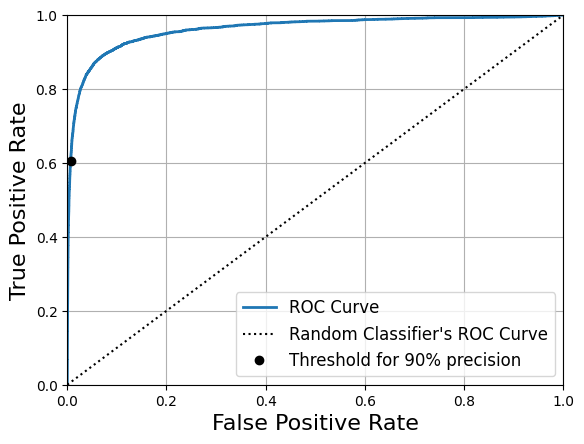

In [67]:
# Let's get the false positive and true positive the roc curve using sklearn
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
# Let's plot the FPR against TPR
idx_threshold_90_precision = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_threshold_90_precision], fpr[idx_threshold_90_precision]

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
    plt.plot([0, 1], [0, 1], 'k:', label="Random Classifier's ROC Curve")
    
    # Beautifying the graph
    plt.xlim(0.0, np.max(fpr))
    plt.ylim(0.0, np.max(tpr))
    plt.grid(True)
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)

plot_roc_curve(fpr, tpr)
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.legend(loc="lower right", fontsize=12)
plt.show()

* Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces
* The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible
* One way to compare classifiers is to measure the <b>area under the curve (AUC)</b>
* A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [69]:
# Let's calculate the ROC AUC for the classifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.962197058539533

### $\color{red}{\text{Important Note}}$
* Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use
* As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives
* Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s)
* In contrast, the PR curve makes it clear that the classifier has room for improvement: the curve could really be closer to the top-right corner

In [74]:
# Let's create a RandomForestClassifier and compare it to SGDClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

* The precision_recall_curve() function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance
* But the RandomForestClassifier class does not have a decision_function() method, due to the way it works
* It has a predict_proba() method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score
* We can call the cross_val_predict() function to train the RandomForestClassifier using cross-validation and make it predict class probabilities for every image

In [76]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")
y_probas_forest

array([[0.24, 0.76],
       [0.99, 0.01],
       [0.98, 0.02],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.94, 0.06]])

* This gives probability of the image being negative or positive
* The first index in each vector of the array represents the probability of image being positive (It is a 5) and the second gives the probability of image being negative(not a 5)
* For this example the model predicts that the first image is positive with a 76% probability and the second image is negative with a 99% probablity

In [79]:
# Second column contains the estimated probs. for the positive class 
# so let's pass them to the precision_recall_curve() function
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

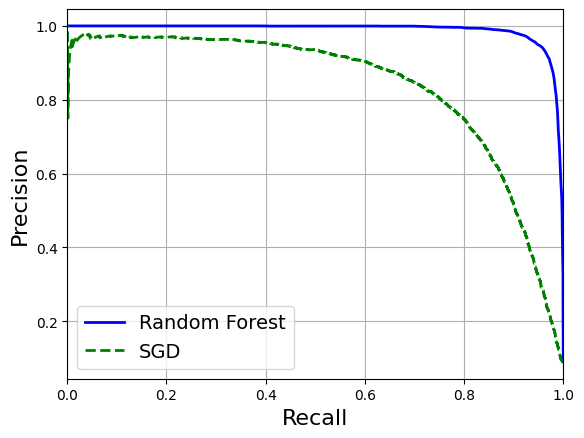

In [88]:
# Let's now plot the precision vs recall curve
plot_precision_recall_curve(precisions_forest, recalls_forest, "Random Forest", "b-")
plot_precision_recall_curve(precisions, recalls, 'SGD', 'g--')
plt.legend(fontsize=14)
plt.show()

In [92]:
# Let's look at the F1 score and ROC AUC
y_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba >= 50%
print(f"Random Forest Classifeir F1 Score: {f1_score(y_train_5, y_pred_forest)}")

print(f"Random Forest Classifeir ROC AUC: {roc_auc_score(y_train_5, y_scores_forest)}")

Random Forest Classifeir F1 Score: 0.9259024699176693
Random Forest Classifeir ROC AUC: 0.9982151267100247


In [102]:
# Let's look at the precision and recall
print(f"Random Forest Classifeir Precision : {precision_score(y_train_5, y_pred_forest)}")
print(f"Random Forest Classifeir Recall : {recall_score(y_train_5, y_pred_forest)}")

Random Forest Classifeir Precision : 0.9891745602165088
Random Forest Classifeir Recall : 0.8702380952380953


* As can be seen that the RandomForestClassifier's Precision Recall (PR) curve looks much better that the SGD Classifier's: It comes much closer to the top-right corner
* Its F1 score and ROC AUC score are also significantly better
* 98.9% precision and 87.0% recall.

### $\color{red}{\text{Important Steps to Binary Classification}}$
* choose the appropriate metricfor your task
* evaluate your classifiers using cross-validation
* select the precision/recall trade-off that fits your needs
* use several metrics and curves to compare various models